In [1]:
import networkx as nx

In [2]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda
from keras.callbacks import LambdaCallback
from keras.utils import to_categorical

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from joypy import joyplot

In [6]:
import pandas as pd
import numpy as np

---

In [7]:
SEED = 123

In [8]:
np.random.seed(SEED)

## Dataset

In [9]:
n_features = 32
n_labels = 2

In [10]:
X, y = make_blobs(
    n_samples=5_000,
    n_features=n_features,
    centers=n_labels,
    cluster_std=40,  # centers are (-10, +10)
    random_state=SEED,
)

In [ ]:
X = StandardScaler().fit_transform(X)

if n_labels > 2:
    y = to_categorical(y, n_labels)

## Models

In [11]:
layer_sizes = [32, 32, 16, 16]
dropout_per = .4
activation = 'relu'

In [12]:
output_size = 1 if n_labels == 2 else n_labels
output_activation = 'sigmoid' if n_labels == 2 else 'softmax'
loss = 'binary_crossentropy' if n_labels == 2 else 'categorical_crossentropy'

---

In [13]:
models = {}

In [14]:
models['no dropout'] = Sequential(
    [Dense(s, activation='relu') for s in layer_sizes] +
    [Dense(output_size, activation='sigmoid')]
)

In [15]:
# ignoring the entire neuron, a random one each time
models['classic dropout'] = Sequential(
    sum([[Dense(s, activation=activation), Dropout(dropout_per)] for s in layer_sizes], []) +
    [Dense(output_size, activation=output_activation)]
)

In [16]:
# ignoring the entire neuron, the same time every time
masks = [
    np.random.random(s)[np.newaxis] > dropout_per
    for s in [*layer_sizes[1:], output_size]
]

models['static dropout'] = Sequential(
    sum([[Dense(s, activation=activation), Lambda(lambda x: x * m)] for s, m in zip(layer_sizes, masks)], []) +
    [Dense(output_size, activation=output_activation)]
)

In [17]:
from connections_generation import generate_masks, current_cond_dists
from bio_do import CustomConnections, MaskAdvancer

In [18]:
# ignoring some neuron connections, and over time adding more
masks = generate_masks([n_features, *layer_sizes, output_size], current_cond_dists())

models['bio dropout'] = Sequential(
    [CustomConnections(s, m, activation=activation) for s, m in zip(layer_sizes, masks)] +
    [CustomConnections(output_size, masks[-1], activation=output_activation)]
)

In [19]:
for model in models.values():
    model.compile(loss=loss, 
                  optimizer='adam', 
                  metrics=['accuracy'])

## Training

In [20]:
weights_histories = {}
perf_histories = {}

In [21]:
epochs = 101
add_every = 20

In [22]:
%%time
for name, model in models.items():
    print('\n\n', name)
    
    weights_history = []
    log_weights = LambdaCallback(
        on_epoch_begin=lambda epoch, logs: weights_history.append(model.get_weights())
    )
    callbacks = [log_weights]
    
    if name == 'bio dropout':
        callbacks.append(MaskAdvancer(add_every))
    
    h = model.fit(X, y,
                  validation_split=.3,
                  epochs=epochs, batch_size=64,
                  verbose=1,
                  callbacks=callbacks,
                 )
    
    weights_histories[name] = weights_history
    perf_histories[name] = h.history



 no dropout
Train on 3500 samples, validate on 1500 samples
Epoch 1/101
3500/3500 [==============================] - 0s 113us/step - loss: 0.6864 - acc: 0.5480 - val_loss: 0.6715 - val_acc: 0.6067
Epoch 2/101
3500/3500 [==============================] - 0s 20us/step - loss: 0.6538 - acc: 0.6191 - val_loss: 0.6409 - val_acc: 0.6427
Epoch 3/101
3500/3500 [==============================] - 0s 20us/step - loss: 0.6209 - acc: 0.6566 - val_loss: 0.6268 - val_acc: 0.6573
Epoch 4/101
3500/3500 [==============================] - 0s 20us/step - loss: 0.6013 - acc: 0.6771 - val_loss: 0.6276 - val_acc: 0.6640
Epoch 5/101
3500/3500 [==============================] - 0s 20us/step - loss: 0.5896 - acc: 0.6877 - val_loss: 0.6380 - val_acc: 0.6653
Epoch 6/101
3500/3500 [==============================] - 0s 20us/step - loss: 0.5807 - acc: 0.6980 - val_loss: 0.6276 - val_acc: 0.6733
Epoch 7/101
3500/3500 [==============================] - 0s 20us/step - loss: 0.5707 - acc: 0.7043 - val_loss: 0.6293 - v

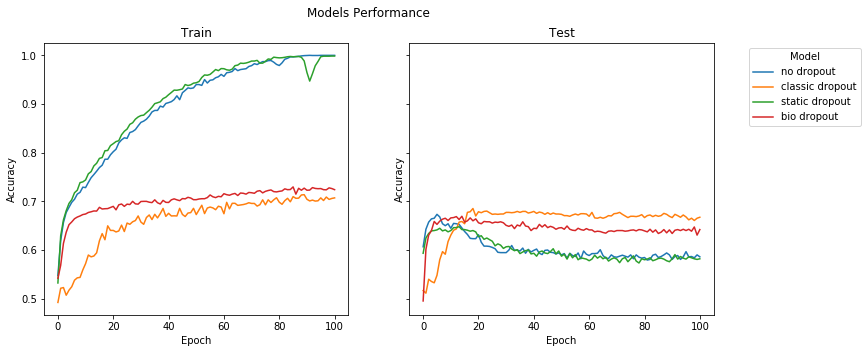

In [23]:
f, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

for name, perf in perf_histories.items():
    ax1.plot(perf['acc'], label=name)
    ax2.plot(perf['val_acc'], label=name)

ax1.set_title('Train')
ax2.set_title('Test')

for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')

ax2.legend(title='Model', bbox_to_anchor=(1.5, 1))

plt.suptitle('Models Performance')
plt.show()

## Node importance

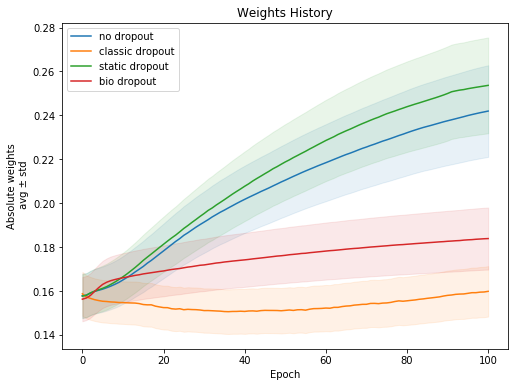

In [44]:
plt.figure(figsize=(8, 6))

for i, (name, weights_history) in enumerate(weights_histories.items()):
    avgs = []
    stds = []
    for epoch_weights in weights_history:
        flattened_weights = np.concatenate([
            abs(w).reshape(-1)
            for w in epoch_weights
        ])
        avgs.append(flattened_weights.mean())
        stds.append(flattened_weights.std())
        
    avgs = np.array(avgs)
    stds = np.array(stds) * .1
    
    color = f'C{i}'
    plt.plot(avgs, label=name, c=color)
    plt.fill_between(range(len(weights_history)), avgs-stds, avgs+stds, 
                     color=color, alpha=.1)
    
plt.xlabel('Epoch')
plt.ylabel('Absolute weights\n avg ± std')

plt.title('Weights History')
plt.legend()
plt.show()

In [25]:
%%time
pr_histories = {}
for name, weights_history in weights_histories.items():
    
    prs = []
    for w in weights_history:
        G = nx.DiGraph()
        weights = w[::2]

        # layer zero is the input
        for l in range(len(layer_sizes)):
            w = abs(weights[l])

            for n1 in range(w.shape[0]):
                for n2 in range(w.shape[1]):
                    G.add_edge(
                        f'layer{l}_node{n1}',
                        f'layer{l+1}_node{n2}',
                        weight=w[n1, n2]
                    )
        
        pr = nx.pagerank(G)
        prs.append(pd.Series(pr))
        
    pr_histories[name] = prs

CPU times: user 42.9 s, sys: 52.6 ms, total: 42.9 s
Wall time: 42.9 s


In [26]:
epochs_mod = 5

In [27]:
ylim = .03

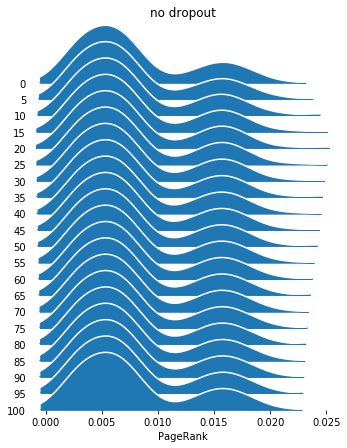

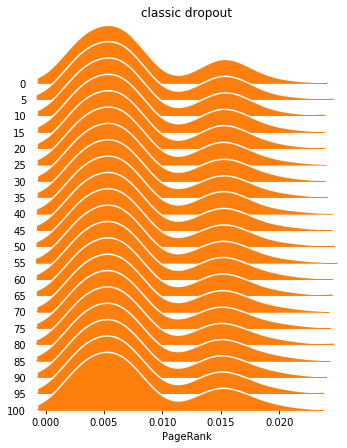

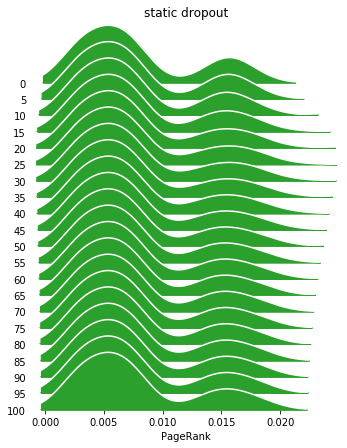

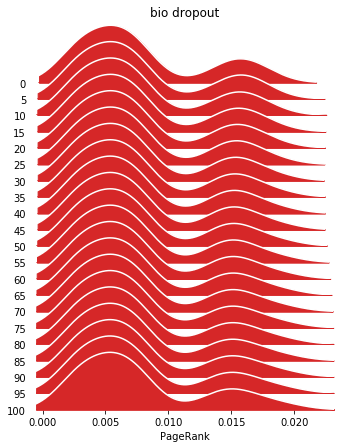

In [28]:
for i, (model, prs) in enumerate(pr_histories.items()):
    df = pd.DataFrame(prs)
    df['epoch'] = df.index
    df = df.melt(id_vars='epoch', value_name='PR')
    
    #print(f'{model} variation of distribution means, by epoch:', df.groupby('Epoch').PR.mean().std())
    df = df[(df.epoch % epochs_mod) == 0]  # keep only epochs divisible by epoch_mod
    
    joyplot(df, column='PR', by='epoch', 
            bins=40, range_style='own', ylim=ylim,
            figsize=(5, 6),
            color=f'C{i}', linecolor='white')

    plt.xlabel('PageRank')
    plt.title(model)
    plt.show()

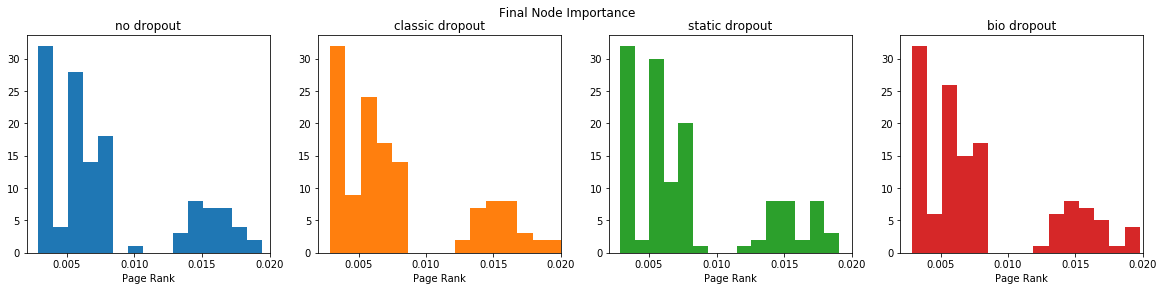

In [83]:
plt.figure(figsize=(20, 4))
plt.suptitle('Final Node Importance')

for i, (model, prs) in enumerate(pr_histories.items()):
    pr = prs[-1]
    
    plt.subplot(1, 4, i+1)
    pr.hist(bins=15, 
            grid='off', color=f'C{i}')
    
    plt.title(model)
    plt.xlim(None, .02)
    plt.xlabel('Page Rank')
    
    plt.locator_params(axis='x', nbins=4)